In [2]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import acquire

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)



In [3]:
original_df = acquire.get_news_articles()

In [5]:
df = original_df[['content','category']]

In [7]:
df.category.value_counts()

entertainment    25
technology       25
business         25
sports           25
Name: category, dtype: int64

In [8]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string
df = df.assign(normalized = df.content.apply(normalize))

In [9]:
df.head()

,content,category,normalized
0,Former Finance Minister P Chidambaram on Thurs...,business,former finance minister chidambaram thursday...
1,Google Co-founders Sergey Brin and Larry Page ...,business,google founders sergey brin and larry page ad...
2,Google's 47-year-old India-born CEO Sundar Pic...,business,google year old india born ceo sundar pich...
3,"SoftBank Founder and CEO Masayoshi Son, in a d...",business,softbank founder and ceo masayoshi son disc...
4,In a bid to provide relief to depositors of sc...,business,bid provide relief depositors scam hit punj...


In [10]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [11]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [12]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [13]:
def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

In [17]:
def prep_articles(df):
    df = df.assign(original = df.content)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.stemmed.apply(remove_stopwords))
    df.drop(columns=["content"], inplace=True)
    return df

def prep_news_articles(text, target):
    df = acquire.get_news_articles()
    df = df[[text, target]]
    df = prep_articles(df)
    return df

In [18]:
df = prep_news_articles('content','category')

In [20]:
df.category.value_counts(normalize=True)
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
entertainment,25,0.25
technology,25,0.25
business,25,0.25
sports,25,0.25


In [21]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

Text(0.5, 1.0, '10 most common words')

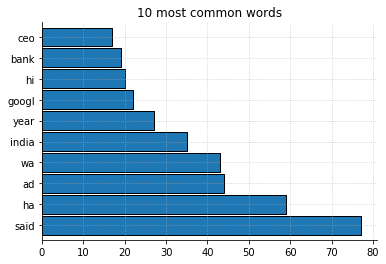

In [22]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

In [23]:
tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
said,77,0.021300,1.000000
ha,59,0.016321,0.766234
ad,44,0.012172,0.571429
wa,43,0.011895,0.558442
india,35,0.009682,0.454545


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df.cleaned)

In [28]:
features_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features_df.head()

,aaliyah,aamir,aay,abdul,abil,abl,absolut,abus,acceler,accept,...,yeah,year,yellow,yet,york,young,youni,youth,youtub,yuvraj
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.106221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.088785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.188218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X = tfidf.fit_transform(df.cleaned)
y= df.category

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [32]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [33]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 96.25%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business             18              0       0           1
entertainment         0             20       0           0
sports                0              0      20           0
technology            2              0       0          19
---
               precision    recall  f1-score   support

     business       0.95      0.90      0.92        20
entertainment       1.00      1.00      1.00        20
       sports       1.00      1.00      1.00        20
   technology       0.90      0.95      0.93        20

     accuracy                           0.96        80
    macro avg       0.96      0.96      0.96        80
 weighted avg       0.96      0.96      0.96        80

